In [49]:
%load_ext autoreload
%autoreload 2
import sys

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
        
from datetime import datetime
import gc
import pandas as pd
from pathlib import Path
from ams.config import constants, logger_factory
from ams.services import twitter_service
from ams.services import ticker_service
from ams.notebooks.twitter.twitter_ml_utils import  get_data_for_predictions
from ams.notebooks.twitter import twitter_ml_utils
from ams.utils import date_utils
import xgboost as xgb
from ams.machine_learning.twitter import pred_perf_testing
from datetime import timedelta
from typing import Dict
import collections

%matplotlib inline

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

logger = logger_factory.create(__name__)

gc.collect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


4

In [50]:
def is_good_date(dt):
    result = True
    if date_utils.is_stock_market_closed(dt):
        logger.info("No can do. Market closed.")
        result = False
    return result

def get_stock_matchable(df):
    tickers = list(set(df["f22_ticker"].to_list()))
    
    good_tickers = []
    for t in tickers:
        if ticker_service.does_ticker_data_exist(ticker=t):
            good_tickers.append(t)
    
    return df[df["f22_ticker"].isin(good_tickers)]

In [51]:
%%time
overall_roi = []
overall_roi = None
df_rec_quart_drop = None

learning_prep_dir = Path(constants.TWITTER_GREAT_REDUCTION_DIR, "main")
df_tweets = twitter_ml_utils.load_twitter_raw(learning_prep_dir=learning_prep_dir)
df_tweets_joinable = get_stock_matchable(df=df_tweets)

Wall time: 939 ms


In [89]:
Startup = collections.namedtuple("Startup", "dt_start predict_date_str num_hold_days min_date_str max_date_str")

def get_start_up(start_date_str: str, num_hold_days) -> Startup:
    dt_start = date_utils.parse_std_datestring(start_date_str)
    predict_date_str = date_utils.get_standard_ymd_format(dt_start)
    
    min_date_str = "2020-08-10"
    max_date_str = "2021-01-18"
    
    return Startup(dt_start=dt_start,
                   predict_date_str=predict_date_str,
                   min_date_str=min_date_str,
                   max_date_str=max_date_str,
                   num_hold_days=num_hold_days)

df_tweets_ready = df_tweets_joinable
s = get_start_up(start_date_str="2020-11-18", num_hold_days=5)
# df_tweets_ready = df_tweets_joinable.sample(frac=.2)

C:\Users\Chris\workspaces\alpha_media_signal\ams\notebooks\twitter\twitter_ml_utils.py:816: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=[group_column_name], inplace=True)


Wall time: 402 ms


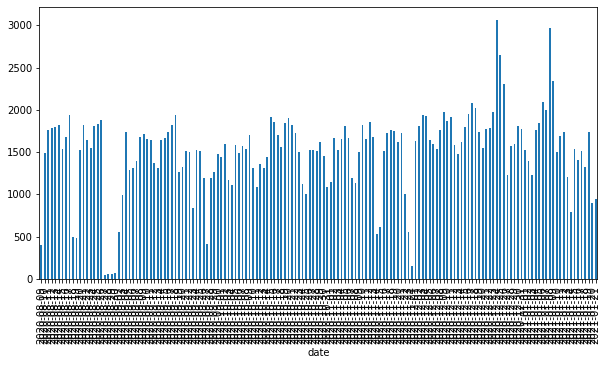

In [90]:
%%time
twitter_ml_utils.show_distribution(df=df_tweets_ready)

In [91]:
%%time
def convert_columns(df):
    df_booled = twitter_service.convert_to_bool(df=df)
    return twitter_ml_utils.convert_twitter_to_numeric(df=df_booled)

df_twitter = convert_columns(df=df_tweets_ready)

print(df_twitter.shape[0])

237922
Wall time: 3.63 s


In [92]:
%%time
def get_stocks_based_on_tweets(df, prediction_date_str, num_hold_days):
    df_stock_tweets = df[df["date"] < prediction_date_str]
    
    if df_stock_tweets.shape[0] == 0:
        print("No data before prediction date.")
        return None

    df_stock_data = twitter_ml_utils.get_twitter_stock_data_2(df_tweets=df_stock_tweets,
                                                            num_hold_days=num_hold_days)
    
    prediction_tickers = list(df[df["date"] == prediction_date_str]["f22_ticker"].unique())

    future_date = twitter_ml_utils.get_next_market_date(prediction_date_str, num_hold_days)

    rows = []
    attributes = ("volume", "open", "low", "high", "close", "date")
    for t in prediction_tickers:
        prev_volume, prev_open, prev_low, prev_high, prev_close, prev_date = \
        ticker_service.get_most_recent_stock_values(ticker=t, 
                                                    attributes=attributes, 
                                                    before_date_str=prediction_date_str)
        
        rows.append({"ticker": t, "date": prediction_date_str, "future_date": future_date,
                     "prev_volume": prev_volume, "prev_open": prev_open, "prev_low": prev_low, 
                     "prev_high": prev_high, "prev_close": prev_close, "prev_date": prev_date
                    })

    df_stock_predict_data = pd.DataFrame(rows)

    return pd.concat([df_stock_data, df_stock_predict_data], axis=0)

df_sd_futured = get_stocks_based_on_tweets(df=df_twitter, prediction_date_str=s.predict_date_str, num_hold_days=s.num_hold_days)

Wall time: 1min 37s


In [93]:
print(df_sd_futured.shape[0])
print(list(df_sd_futured.columns))

90701
['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividends', 'closeunadj', 'lastupdated', 'prev_date', 'prev_open', 'prev_low', 'prev_high', 'prev_close', 'prev_volume', 'future_open', 'future_low', 'future_high', 'future_close', 'future_date', 'None']


In [94]:
%%time
def get_quarterly_data():
    global df_rec_quart_drop
    if df_rec_quart_drop is None:
        df_rec_quart_drop = twitter_service.get_all_quarterly_data_for_twitter()
    return df_rec_quart_drop.copy()

def combine_with_quarterly_stock_data(df):
    df_rec_quart_drop = get_quarterly_data()
    columns_fundy = list(df_rec_quart_drop.columns)
    df_result = twitter_ml_utils.merge_fundies_with_stock(df_stock_data=df)
    df_drop_init = df_result.dropna(subset=["date"]).copy().drop(columns="lastupdated_eq_fun").copy()
    df_drop_future = df_drop_init[df_drop_init["date"] > df_drop_init["calendardate"]].copy()
    df_drop_future = df_drop_future.sort_values(by=["ticker", "date", "calendardate"], ascending=False).copy()
    df_stock_and_quarter = df_drop_future.drop_duplicates(subset=["ticker", "date"], keep="first").copy()
    logger.info("Finished merging in quarterly stock data.")
    
    return df_stock_and_quarter, columns_fundy

df_stock_and_quarter, columns_fundy = combine_with_quarterly_stock_data(df=df_sd_futured)

2021-01-22 00:25:56,170 - __main__ - INFO - Finished merging in quarterly stock data.
Wall time: 27.3 s


In [95]:
print(df_stock_and_quarter.shape[0])
print(list(df_stock_and_quarter.columns))

82185
['ticker', 'dimension', 'calendardate', 'datekey', 'reportperiod', 'lastupdated', 'accoci', 'assets', 'assetsavg', 'assetsc', 'assetsnc', 'assetturnover', 'bvps', 'capex', 'cashneq', 'cashnequsd', 'cor', 'consolinc', 'currentratio', 'de', 'debt', 'debtc', 'debtnc', 'debtusd', 'deferredrev', 'depamor', 'deposits', 'divyield', 'dps', 'ebit', 'ebitda', 'ebitdamargin', 'ebitdausd', 'ebitusd', 'ebt', 'eps', 'epsdil', 'epsusd', 'equity', 'equityavg', 'equityusd', 'ev', 'evebit', 'evebitda', 'fcf', 'fcfps', 'fxusd', 'gp', 'grossmargin', 'intangibles', 'intexp', 'invcap', 'invcapavg', 'inventory', 'investments', 'investmentsc', 'investmentsnc', 'liabilities', 'liabilitiesc', 'liabilitiesnc', 'marketcap', 'ncf', 'ncfbus', 'ncfcommon', 'ncfdebt', 'ncfdiv', 'ncff', 'ncfi', 'ncfinv', 'ncfo', 'ncfx', 'netinc', 'netinccmn', 'netinccmnusd', 'netincdis', 'netincnci', 'netmargin', 'opex', 'opinc', 'payables', 'payoutratio', 'pb', 'pe', 'pe1', 'ppnenet', 'prefdivis', 'price', 'ps', 'ps1', 'receiva

In [96]:
%%time
def merge_tweets_with_stock_data(df_twitter, df_stock_and_quarter):
    df_nas_tickers_info = ticker_service.get_nasdaq_tickers()

    col_ticker = "ticker_drop"
    
    df_stock_quart_info = pd.merge(df_stock_and_quarter, df_nas_tickers_info, how='inner', left_on=["ticker"], right_on=[col_ticker])
    df_stock_quart_info.drop(columns=[col_ticker], inplace=True)

    df_stock_renamed = df_stock_quart_info.rename(columns={"ticker": "f22_ticker"})
    
    if 'None' in df_stock_renamed.columns:
        df_stock_renamed.drop(columns=['None'], inplace=True)
        
    df_merged = pd.merge(df_twitter, df_stock_renamed, how='inner', on=["f22_ticker", "date"])
    
    df_merged.sort_values(by=["f22_ticker", "date"], inplace=True)
    
    if df_merged.shape[0] == 0:
        logger.info("Not enough data after merge.")
        
    df_ranked = twitter_ml_utils.add_tip_ranks(df=df_merged, tr_file_path=constants.TIP_RANKED_DATA_PATH)
    
    return df_ranked

print(df_twitter.shape[0])
print(df_stock_and_quarter.shape[0])

df_merged = merge_tweets_with_stock_data(df_twitter=df_twitter, 
                                         df_stock_and_quarter=df_stock_and_quarter)

237922
82185


c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Wall time: 6.31 s


In [97]:
print(df_merged.shape[0])
print(list(df_merged.columns))

82180
['created_at', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_statuses_count', 'user_protected', 'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 'possibly_sensitive', 'user_friends_count', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_ticker', 'f22_has_cashtag', 'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_id', 'created_at_timestamp', 'date', 'f22_compound_score', 'f22_is_tweet_after_hours', 'dimension', 'calendardate', 'datekey', 'reportperiod', 'lastupdated', 'accoci', 'assets', 'assetsavg', 'assetsc', 'assetsnc', 'assetturnover', 'bvps', 'capex', 'cashneq', 'cashnequsd', 'cor', 'consolinc', 'currentratio', 'de', 'debt', 'debtc', 'deb

In [98]:
%%time

# predict_date_str = s.predict_date_str
# num_hold_days = s.num_hold_days
# df = df_merged

# cols_fundy_numeric = list(set(columns_fundy) - {"ticker", 'calendardate', 'datekey', 'reportperiod'})

# df = twitter_ml_utils.add_days_since_quarter_results(df=df)
# df = twitter_ml_utils.add_calendar_days(df=df)
# df = twitter_ml_utils.add_nasdaq_roi_new(df=df, num_hold_days=num_hold_days)

# # FIXME: 2021-01-15: chris.flesche: "close" should be approximated for when predicting (?)
# df.loc[:, "original_close_price"] = df["close"]

# df = twitter_service.fill_null_numeric(df=df, cols_fundy_numeric=cols_fundy_numeric)

# df_train = df[df["date"] < predict_date_str].copy()

# if df_train.shape[0] == 0:
#     print("Training data not found.")

# df_train = twitter_ml_utils.add_sma_stuff(df=df_train, predict_date_str=predict_date_str)

Wall time: 0 ns


In [99]:
# %%time
# df_predict = df[df["date"] == predict_date_str].copy()
# print(df_predict.shape[0])
# print(df_predict[["f22_ticker", "prev_date"]].head())
# if df_predict.shape[0] > 0:
#     df_predict = twitter_ml_utils.add_sma_stuff(df=df_predict, predict_date_str=predict_date_str, sma_day_before=True)
#     df_concatted = pd.concat([df_train, df_predict], axis=0)

#     print(f"df_predict after concat: {df_concatted.shape[0]}")
# else:
#     print("Prediction data not found.")

# df.loc[:, "purchase_date"] = df["date"]

# df = ticker_service.add_days_until_sale(df=df)

In [100]:
%%time
def add_calendar_info(df, predict_date_str, columns_fundy, num_hold_days):
    cols_fundy_numeric = list(set(columns_fundy) - {"ticker", 'calendardate', 'datekey', 'reportperiod'})

    df = twitter_ml_utils.add_days_since_quarter_results(df=df)
    df = twitter_ml_utils.add_calendar_days(df=df)
    df = twitter_ml_utils.add_nasdaq_roi_new(df=df, num_hold_days=num_hold_days)
    
    # FIXME: 2021-01-15: chris.flesche: "close" should be approximated for when predicting (?)
    df.loc[:, "original_close_price"] = df["close"]

    df = twitter_service.fill_null_numeric(df=df, cols_fundy_numeric=cols_fundy_numeric)
    
    df_train = df[df["date"] < predict_date_str].copy()
    
    if df_train.shape[0] == 0:
        return None
    
    df_train = twitter_ml_utils.add_sma_stuff(df=df_train, predict_date_str=predict_date_str)
        
    df_predict = df[df["date"] == predict_date_str].copy()
    if df_predict.shape[0] > 0:
        df_predict = twitter_ml_utils.add_sma_stuff(df=df_predict, predict_date_str=predict_date_str, sma_day_before=True)
        df = pd.concat([df_train, df_predict], axis=0)
        
        print(f"df_predict after concat: {df_predict.shape[0]}")
    else:
        return None
    
    df.loc[:, "purchase_date"] = df["date"]

    df = ticker_service.add_days_until_sale(df=df)
    
    return df

print(df_merged.shape[0])

df_days_until = add_calendar_info(df=df_merged, 
                                  predict_date_str=s.predict_date_str, 
                                  columns_fundy=columns_fundy, 
                                  num_hold_days=s.num_hold_days)

if df_days_until is None:
    raise Exception("Empty result.")

82180
Num rows in play: 82180
  f22_ticker        date   prev_date  close_SMA_200
0        AAL  2020-11-18  2020-11-17      13.807350
1       AAME  2020-11-18  2020-11-17       2.021325
2       AAON  2020-11-18  2020-11-17      55.074825
3       AAPL  2020-11-18  2020-11-17     274.220525
4       AAXN  2020-11-18  2020-11-17      85.813950
df_predict after concat: 1453
Wall time: 2min 31s


In [101]:
%%time
print(df_days_until.shape[0])
df = df_days_until
df_predict = df[df["date"] == predict_date_str].copy()

# df_predict = df_supple[df_supple["date"] == predict_date_str].copy()
print(f"df_predict: {df_predict.shape[0]}")
print(list(df_predict.columns))

82147
df_predict: 0
['date', 'nasdaq_day_roi', 'created_at', 'user_screen_name', 'favorite_count', 'in_reply_to_screen_name', 'user_verified', 'metadata_result_type', 'user_listed_count', 'user_time_zone', 'user_has_extended_profile', 'in_reply_to_status_id', 'user_statuses_count', 'user_protected', 'user_is_translation_enabled', 'user_location', 'lang', 'user_geo_enabled', 'place_country', 'place_name', 'possibly_sensitive', 'user_friends_count', 'retweet_count', 'user_follow_request_sent', 'user_followers_count', 'f22_ticker', 'f22_has_cashtag', 'f22_ticker_in_text', 'f22_num_other_tickers_in_tweet', 'f22_sentiment_pos', 'f22_sentiment_neu', 'f22_sentiment_neg', 'f22_sentiment_compound', 'f22_id', 'created_at_timestamp', 'f22_compound_score', 'f22_is_tweet_after_hours', 'dimension', 'calendardate', 'datekey', 'reportperiod', 'lastupdated', 'accoci', 'assets', 'assetsavg', 'assetsc', 'assetsnc', 'assetturnover', 'bvps', 'capex', 'cashneq', 'cashnequsd', 'cor', 'consolinc', 'currentrat

In [102]:
%%time
def refine_and_drop_cols(df):
    df = twitter_service.refine_pool(df=df, min_volume=None, min_price=None, max_price=None)
    df = twitter_service.omit_columns(df=df)
    return df.drop(columns=["calendardate", "reportperiod", "dimension", "datekey"])

df_refined = refine_and_drop_cols(df_days_until)

Wall time: 209 ms


In [103]:
print(df_refined.shape[0])
df_predict = df_refined[df_refined["date"] == predict_date_str].copy()
print(f"df_predict: {df_predict.shape[0]}")
print(list(df_predict.columns))

82147
df_predict: 0
['industry_Staffing & Employment Services', 'location_Maine; U.S.A', 'category_ADR Common Stock Primary Class', 'industry_REIT - Residential', 'industry_Utilities - Regulated Gas', 'nasdaq_day_roi', 'industry_Auto Manufacturers', 'industry_Business Services', 'rank', 'ps', 'tangibles', 'famaindustry_Construction Materials', 'industry_Electrical Equipment & Parts', 'price', 'famaindustry_Entertainment', 'currency_SEK', 'industry_Mortgage Finance', 'industry_Health Information Services', 'location_United Republic Of Tanzania', 'currency_CNY', 'industry_Broadcasting', 'location_Ohio; U.S.A', 'location_Switzerland', 'liabilitiesnc', 'assetsc', 'industry_Recreational Vehicles', 'location_Alaska; U.S.A', 'payables', 'scalemarketcap_3 - Small', 'equity', 'receivables', 'famaindustry_Defense', 'currency_HKD', 'currency_EUR', 'rank_roi', 'sector_Energy', 'sicsector_Mining', 'location_Nevada; U.S.A', 'revenueusd', 'category_ADR Preferred Stock', 'location_Malta', 'ps1', 'loca

In [104]:
%%time

# NOTE: 2021-01-03: chris.flesche:
# df_winnowed = twitter_ml_utils.truncate_avail_columns(df=df_tweet_counted)

def one_hot(df):
    df_ticker_hotted, unique_tickers = ticker_service.make_f22_ticker_one_hotted(df_ranked=df)

    narrow_cols = list(df_ticker_hotted.columns)

    print(f"Number of train_hotted {df_ticker_hotted.shape[0]}.")
    
    return df_ticker_hotted, narrow_cols

df_ticker_hotted, narrow_cols = one_hot(df=df_refined)

Number of train_hotted 82147.
Wall time: 1.46 s


In [105]:
print(f"df_ticker_hotted: {df_ticker_hotted.shape[0]}")
df_predict = df_ticker_hotted[df_ticker_hotted["date"] == predict_date_str].copy()
print(f"df_predict: {df_predict.shape[0]}")
print(list(df_predict.columns))

df_ticker_hotted: 82147
df_predict: 0
['industry_Staffing & Employment Services', 'location_Maine; U.S.A', 'category_ADR Common Stock Primary Class', 'industry_REIT - Residential', 'industry_Utilities - Regulated Gas', 'nasdaq_day_roi', 'industry_Auto Manufacturers', 'industry_Business Services', 'rank', 'ps', 'tangibles', 'famaindustry_Construction Materials', 'industry_Electrical Equipment & Parts', 'price', 'famaindustry_Entertainment', 'currency_SEK', 'industry_Mortgage Finance', 'industry_Health Information Services', 'location_United Republic Of Tanzania', 'currency_CNY', 'industry_Broadcasting', 'location_Ohio; U.S.A', 'location_Switzerland', 'liabilitiesnc', 'assetsc', 'industry_Recreational Vehicles', 'location_Alaska; U.S.A', 'payables', 'scalemarketcap_3 - Small', 'equity', 'receivables', 'famaindustry_Defense', 'currency_HKD', 'currency_EUR', 'rank_roi', 'sector_Energy', 'sicsector_Mining', 'location_Nevada; U.S.A', 'revenueusd', 'category_ADR Preferred Stock', 'location_Ma

In [106]:
%%time

def supplement_predict(df, predict_date_str: str):
    df_train = df[df["date"] != predict_date_str].copy()
    df_predict = df[df["date"] == predict_date_str].copy()
    
    print(f"df_predict: {df_predict.shape[0]}")
        
    df_predict.loc[:, "open"] = df_predict["prev_open"].copy()
    df_predict.loc[:, "low"] = df_predict["prev_low"].copy()
    df_predict.loc[:, "high"] = df_predict["prev_high"].copy()
    df_predict.loc[:, "close"] = df_predict["prev_close"].copy()
    df_predict.loc[:, "original_close_price"] = df_predict["prev_close"].copy()
    
    df_combined = pd.concat([df_train, df_predict], axis=0).reset_index(drop=True)
    
    return df_combined

df_predict = df_ticker_hotted[df_ticker_hotted["date"] == predict_date_str].copy()
print(f"df_predict: {df_predict.shape[0]}")
# print(list(df_predict.columns))

df_supple = supplement_predict(df=df_ticker_hotted, predict_date_str=s.predict_date_str)
print(df_supple.shape[0])

df_predict = df_supple[df_supple["date"] == predict_date_str].copy()
print(f"df_predict: {df_predict.shape[0]}")
print(list(df_predict.columns))

df_predict: 0
df_predict: 1453
82147
df_predict: 0
['industry_Staffing & Employment Services', 'location_Maine; U.S.A', 'category_ADR Common Stock Primary Class', 'industry_REIT - Residential', 'industry_Utilities - Regulated Gas', 'nasdaq_day_roi', 'industry_Auto Manufacturers', 'industry_Business Services', 'rank', 'ps', 'tangibles', 'famaindustry_Construction Materials', 'industry_Electrical Equipment & Parts', 'price', 'famaindustry_Entertainment', 'currency_SEK', 'industry_Mortgage Finance', 'industry_Health Information Services', 'location_United Republic Of Tanzania', 'currency_CNY', 'industry_Broadcasting', 'location_Ohio; U.S.A', 'location_Switzerland', 'liabilitiesnc', 'assetsc', 'industry_Recreational Vehicles', 'location_Alaska; U.S.A', 'payables', 'scalemarketcap_3 - Small', 'equity', 'receivables', 'famaindustry_Defense', 'currency_HKD', 'currency_EUR', 'rank_roi', 'sector_Energy', 'sicsector_Mining', 'location_Nevada; U.S.A', 'revenueusd', 'category_ADR Preferred Stock',

In [107]:
%%time
def train_predict(df_train, df_predict, narrow_cols):
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
        X_train, y_train, standard_scaler = twitter_ml_utils.transform_to_numpy(df=df_train, narrow_cols=narrow_cols)
        
        if X_train is None or X_train.shape[0] == 0 or y_train is None:
            print("Not enough training data.")
            return None

        model = xgb.XGBClassifier(max_depth=4)
        model.fit(X_train, y_train)

    X_predict = get_data_for_predictions(df=df_predict, narrow_cols=narrow_cols, standard_scaler=standard_scaler)

    logger.info("Invoking model prediction ...")
    prediction = model.predict(X_predict)
    
    df_predict.loc[:, "prediction"] = prediction

    return df_predict

df_train, df_predict = twitter_ml_utils.split_train_predict(df=df_supple, predict_date_str=s.predict_date_str)

# print(f"df_train: {df_train.shape[0]}")
# print(f"df_predict: {df_predict.shape[0]}")
# print(df_train[["buy_sell"]].head())
    
if df_train is None or df_predict is None or df_predict.shape[0] == 0 or df_train.shape[0] == 0:
    logger.info(f"Not enough data on {s.predict_date_str}")
    raise Exception("Error!")
    
df_predict = train_predict(df_train=df_train, df_predict=df_predict, narrow_cols=narrow_cols)

2021-01-22 00:28:41,692 - ams.notebooks.twitter.twitter_ml_utils - INFO - Num rows of prepared data: 80694
2021-01-22 00:28:41,706 - ams.notebooks.twitter.twitter_ml_utils - INFO - Oldest date of prepared data (future_date): 2020-11-23
balanced data: 65850


c:\programdata\miniconda3\envs\alpha_media_signal\lib\site-packages\sklearn\utils\extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


2021-01-22 00:29:44,427 - __main__ - INFO - Invoking model prediction ...
Wall time: 1min 4s


In [108]:
print(f"df_train: {df_train.shape[0]}")
print(f"df_predict: {df_predict.shape[0]}")
# print(list(df_predict.columns))

df_train: 80694
df_predict: 1453


In [109]:
%%time

def persist_predictions(df_buy, predict_date_str: str, num_hold_days: int):
    overwrite_file = False
    df_preds = pd.read_csv(constants.TWITTER_PREDICTIONS_PATH)
    df_preds = df_preds[~((df_preds["purchase_date"] == predict_date_str) & (df_preds["num_hold_days"] == num_hold_days))]

    logger.info(f"Old rows found: {df_preds.shape[0]}")

    if overwrite_file:
        df_combined = df_buy
    else:
        df_combined = pd.concat([df_preds, df_buy], axis=0)

    logger.info("Writing predictions to output ...")
    df_combined.to_csv(constants.TWITTER_PREDICTIONS_PATH, index=False)

def show_prediction_results(df_predict, predict_date_str, num_hold_days):
    df_buy = df_predict[df_predict["prediction"] == 1][["f22_ticker", "purchase_date", "future_date"]].copy()
    
    if df_buy is None or df_buy.shape[0] == 0:
        print("No buy predictions.")
        return None, None
    
    df_buy.loc[:, "num_hold_days"] = num_hold_days
    df_buy.loc[:, "run_timestamp"] = datetime.timestamp(datetime.now())
    
    persist_predictions(df_buy=df_buy, predict_date_str=predict_date_str, num_hold_days=num_hold_days)

    days_roi_1 = pred_perf_testing.get_days_roi_from_prediction_table(df_preds=df_buy, date_str=predict_date_str, num_hold_days=num_hold_days)

    days_roi_5 = pred_perf_testing.get_days_roi_from_prediction_table(df_preds=df_buy, date_str=predict_date_str, num_hold_days=5)

    return days_roi_1, days_roi_5
 
roi_1_day, roi_5_days = show_prediction_results(df_predict, s.predict_date_str, s.num_hold_days)
print(f"{s.predict_date_str}: Roi 1: {roi_1_day}: 5: {roi_5_days}")

No buy predictions.
2020-11-18: Roi 1: None: 5: None
Wall time: 2 ms


In [ ]:
def predict_day(df, predict_date_str: str, num_hold_days: int):
    df_twitter = convert_columns(df=df)
    
    df_sd_futured = get_stocks_based_on_tweets(df=df_twitter, prediction_date_str=predict_date_str, num_hold_days=num_hold_days)
    df_stock_and_quarter, columns_fundy = combine_with_quarterly_stock_data(df=df_sd_futured)
    df_merged = merge_tweets_with_stock_data(df_twitter=df_twitter, df_stock_and_quarter=df_stock_and_quarter)
    
    df_days_until = add_calendar_info(df=df_merged, 
                                      predict_date_str=predict_date_str, 
                                      columns_fundy=columns_fundy,
                                      num_hold_days=num_hold_days)
    
    if df_days_until is None:
        print("Not enough data after stocks and calendar info added.")
        return None
    
    df_refined = refine_and_drop_cols(df_days_until)
        
    df_ticker_hotted, narrow_cols = one_hot(df=df_refined)
    
    if df_ticker_hotted is None or df_ticker_hotted.shape[0] == 0:
        logger.info(f"Not enough data on {predict_date_str}")
        return None
    
    df_supple = supplement_predict(df=df_ticker_hotted, predict_date_str=predict_date_str)
    
    df_train, df_predict = twitter_ml_utils.split_train_predict(df=df_supple, predict_date_str=predict_date_str)
    
    if df_train is None or df_predict is None or df_predict.shape[0] == 0 or df_train.shape[0] == 0:
        logger.info(f"Not enough data on {predict_date_str}")
        return None

    df_predict = train_predict(df_train=df_train, df_predict=df_predict, narrow_cols=narrow_cols)
    if df_predict is None or df_predict.shape[0] == 0:
        print("Not enough data to predict.")
        return None
    
    roi_1_day, roi_5_days = show_prediction_results(df_predict, predict_date_str, num_hold_days)
    print(f"Roi 1: {roi_1_day}: 5: {roi_5_days}")
    
    return roi_1_day

# roi_day = predict_day(df=df_tweets_for_day, predict_date_str=s.predict_date_str, num_hold_days=s.num_hold_days)
# print(roi_day)

In [ ]:
%%time
from statistics import mean
import collections

# df_tweets_joinable = df_tweets_joinable.sample(frac=.15)

s = get_start_up(start_date_str="2020-08-10", num_hold_days=5)
dt_start = s.dt_start
all_roi = []
min_train_size = 500

while s.min_date_str <= s.predict_date_str <= s.max_date_str:
    while not is_good_date(dt=dt_start):
        dt_start = dt_start + timedelta(days=1)
        
    predict_date_str = date_utils.get_standard_ymd_format(dt_start)
    
    df_tweets_for_day = df_tweets_ready[df_tweets_ready["date"] <= predict_date_str].copy()
    
    df_train = df_tweets_ready[df_tweets_ready["date"] < predict_date_str].copy()
    df_predict = df_tweets_ready[df_tweets_ready["date"] == predict_date_str].copy()
    
    if df_train.shape[0] > min_train_size and df_predict.shape[0] > 0:
        print(f"\nTraining and predicting for {predict_date_str} ...\n")
        roi_day = predict_day(df=df_tweets_for_day, predict_date_str=predict_date_str, num_hold_days=s.num_hold_days)
        if roi_day is not None:
            all_roi.append(roi_day)
    
    dt_start = dt_start + timedelta(days=1)

# print(f"Overall roi: {mean(all_roi)}")

In [ ]:
# Add overall ROI ongoing.(?)
# Add EOD (open, close, high, low) to train and predict. But for predict use previous day. Done
# Fix SMA: prev day for open for predict, regular for all other dates
# Add num days from start
# Add lookup to previous day's prediction roi - seems to follow on-off-on-off pattern.
# Change to WorldTradingDaily real time quotes (12hr) to substitute for open, low, high, and estimate close. (or just take current)
# WTD not necessary when using historical.
# Test yesterday EOD with 4 day estimate.
# Test with historical purchase day eod data (open, close, high, low)
# Change SMA back to use purchase day-base SMA.
# Reprocess all date with by using sums in Great reduction rather than means.